# Kütüphanelerin Yüklenmesi

In [ ]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models  import Sequential, load_model

from glob import glob
import random, os, datetime
import numpy as np
from sklearn.model_selection import train_test_split
import time
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization, Input,Activation
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Accuracy, AUC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC

# Google Drive Bağlantı

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Görüntü İşleme Aşamaları

In [ ]:
img1_paths="/content/drive/MyDrive/Colab Notebooks/imgdr"

In [ ]:
image_paths = [os.path.join(img1_paths, f) for f in os.listdir(img1_paths) if f.endswith(('.jpg', '.jpeg', '.png'))]

In [ ]:
img_list = []

for i in image_paths[0:20]:  # İlk 105 görüntü üzerinde işlem yapılır
    image = cv2.imread(i)  # Doğrudan dosya yolundan oku
    if image is None:
        print(f"{i} dosyası yüklenemedi.")
        continue
    image = cv2.resize(image,(224,224))
    # Renk uzayını RGB'ye çevir
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_list.append(image)

# Görüntülerin listesi başarıyla oluşturulduktan sonra
print(f"Toplam {len(img_list)} görüntü başarıyla yüklendi.")


Toplam 20 görüntü başarıyla yüklendi.


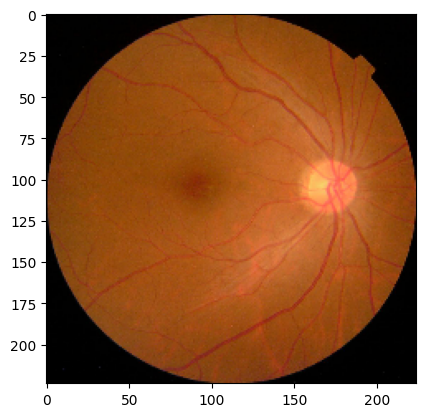

In [ ]:
img=img_list[11]

plt.imshow(img,cmap="gray")

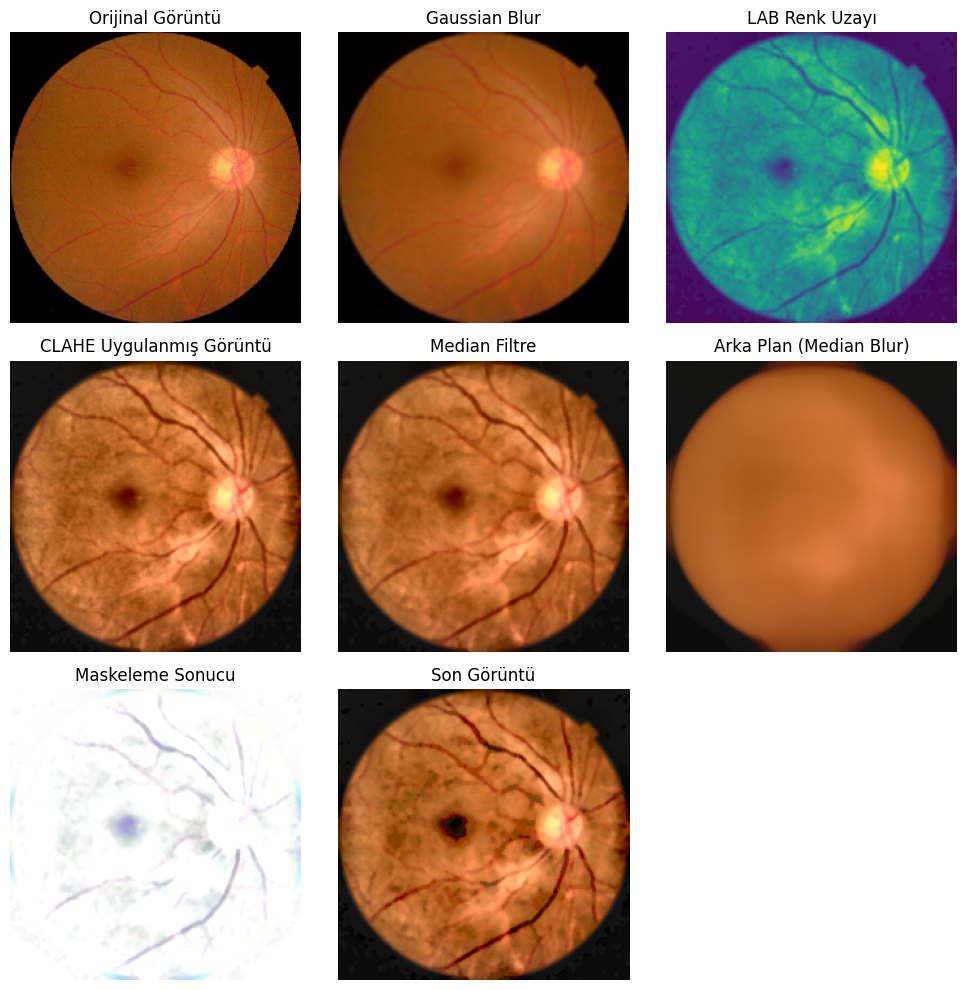

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Gaussian Blur uygulama
blurgaus = cv2.GaussianBlur(img, (5, 5), 0)

# LAB Renk Uzayına Geçiş ve CLAHE Uygulaması

lab = cv2.cvtColor(blurgaus, cv2.COLOR_RGB2LAB)
l, a, b = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=7.0, tileGridSize=(8, 8))
cl = clahe.apply(l)
limg = cv2.merge((cl, a, b))
sonhal = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

# Median Filtre
median_blur = cv2.medianBlur(sonhal, 3)

# Arka plan için median filtre
arkaplan = cv2.medianBlur(sonhal, 55)

# Maskeleme işlemi
maskeleme = cv2.addWeighted(median_blur, 1, arkaplan, -1, 255)

# Son görüntü
son_img = cv2.bitwise_and(maskeleme, median_blur)

# Görüntüleri görselleştirme
plt.figure(figsize=(10, 10))

# Orijinal görüntü
plt.subplot(3, 3, 1)
plt.title("Orijinal Görüntü")
plt.imshow(img,cmap="gray")  # BGR'den RGB'ye dönüştürme
plt.axis("off")

# Gaussian Blur
plt.subplot(3, 3, 2)
plt.title("Gaussian Blur")
plt.imshow(blurgaus)  # BGR'den RGB'ye dönüştürme
plt.axis("off")

# LAB Renk Uzayı
plt.subplot(3, 3, 3)
plt.title("LAB Renk Uzayı")
  # LAB'den RGB'ye dönüştürme
plt.imshow(cl)
plt.axis("off")

# CLAHE uygulanmış görüntü
plt.subplot(3, 3, 4)
plt.title("CLAHE Uygulanmış Görüntü")
plt.imshow(sonhal)
plt.axis("off")

# Median Filtre
plt.subplot(3, 3, 5)
plt.title("Median Filtre")
plt.imshow(median_blur)
plt.axis("off")

# Arka plan
plt.subplot(3, 3, 6)
plt.title("Arka Plan (Median Blur)")
plt.imshow(arkaplan)
plt.axis("off")

# Maskeleme
plt.subplot(3, 3, 7)
plt.title("Maskeleme Sonucu")
plt.imshow(maskeleme)  # BGR'den RGB'ye dönüştürme
plt.axis("off")

# Son Görüntü
plt.subplot(3, 3, 8)
plt.title("Son Görüntü")
plt.imshow(son_img)  # BGR'den RGB'ye dönüştürme
plt.axis("off")

plt.tight_layout()
plt.show()



In [ ]:
img_paths="/content/drive/MyDrive/Colab Notebooks/colored_images"
output_paths="/content/drive/MyDrive/Colab Notebooks/dr_son"

# Görüntü yollarını almak için fonksiyon

def get_image_paths(root_dir, num_images=None):
    all_images = []
    for extension in ["*.jpg", "*.jpeg", "*.png"]:
        all_images.extend(glob(os.path.join(root_dir, "**", extension), recursive=True))
    if num_images is None:
        return all_images
    else:
        return random.sample(all_images, min(num_images, len(all_images)))
# Görüntüleri göstermek için fonksiyon
def display_images(img_list):
    plt.figure(figsize=(15, 6))
    for i, img in enumerate(img_list[90:100]):  # 90'dan 100'e kadar olan 10 görüntüyü gösterir
        plt.subplot(2, 5, i + 1)
        plt.imshow(img.astype("uint8"))
        plt.axis('off')
        plt.title(f'Image {i+1}')
    plt.tight_layout()
    plt.show()

# Gaussian Blur fonksiyonu
def apply_gaussian_blur(img, d=5):
    return cv2.GaussianBlur(img, (d, d), 0)

# CLAHE uygulama fonksiyonu
def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)  # LAB renk uzayına dönüştür
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=7.0, tileGridSize=(8, 8))
    l = clahe.apply(l)  # CLAHE sadece L kanalına uygulanır
    lab = cv2.merge((l, a, b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)  # RGB'ye geri dönüştür

# Median filtre uygulama fonksiyonu
def apply_median_filter(img, ksize=5):
    return cv2.medianBlur(img, ksize)

# Arka plan için median filtre fonksiyonu
def apply_background_median_filter(img, ksize=55):
    return cv2.medianBlur(img, ksize)

# Maskeleme işlemi fonksiyonu
def apply_masking(median_blur, arkaplan):
    return cv2.addWeighted(median_blur, 1, arkaplan, -1, 255)

# Son görüntü fonksiyonu
def apply_final_image(maskeleme, median_blur):
    return cv2.bitwise_and(maskeleme, median_blur)

# Görüntülere işlemleri uygula
def process_images(img_paths):
    processed_images = []  # İşlenmiş görüntülerin tutulacağı liste

    for img_path in img_paths:
        # Görüntüyü yükle
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV'nin BGR formatını RGB'ye dönüştür

        # İşlemleri sırayla uygula
        img_blurred = apply_gaussian_blur(img)  # Gaussian Blur
        img_clahe = apply_clahe(img_blurred)   # CLAHE
        img_median = apply_median_filter(img_clahe)  # Median Filter

        # Arka plan için median filtre
        img_background = apply_background_median_filter(img_clahe)

        # Maskeleme işlemi
        img_masked = apply_masking(img_median, img_background)

        # Son görüntü
        final_img = apply_final_image(img_masked, img_median)

        # İşlenmiş görüntüyü listeye ekle
        processed_images.append(final_img)

    return processed_images


def save_images_with_structure(img_list, img_paths, root_dir, output_dir):
    for img_path, img in zip(img_paths, img_list):
        # Orijinal klasör yapısına göre göreli yolu al
        relative_path = os.path.relpath(img_path, start=root_dir)

        # Çıkış yolu oluştur
        output_path = os.path.join(output_dir, relative_path)

        # Çıkış klasörünü oluştur
        output_dirname = os.path.dirname(output_path)
        if not os.path.exists(output_dirname):
            os.makedirs(output_dirname)

        # Görüntüyü kaydet
        cv2.imwrite(output_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        print(f"Processed image saved at: {output_path}")

##  Grafik Görselleştirme
def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):

    #Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Metrics
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()

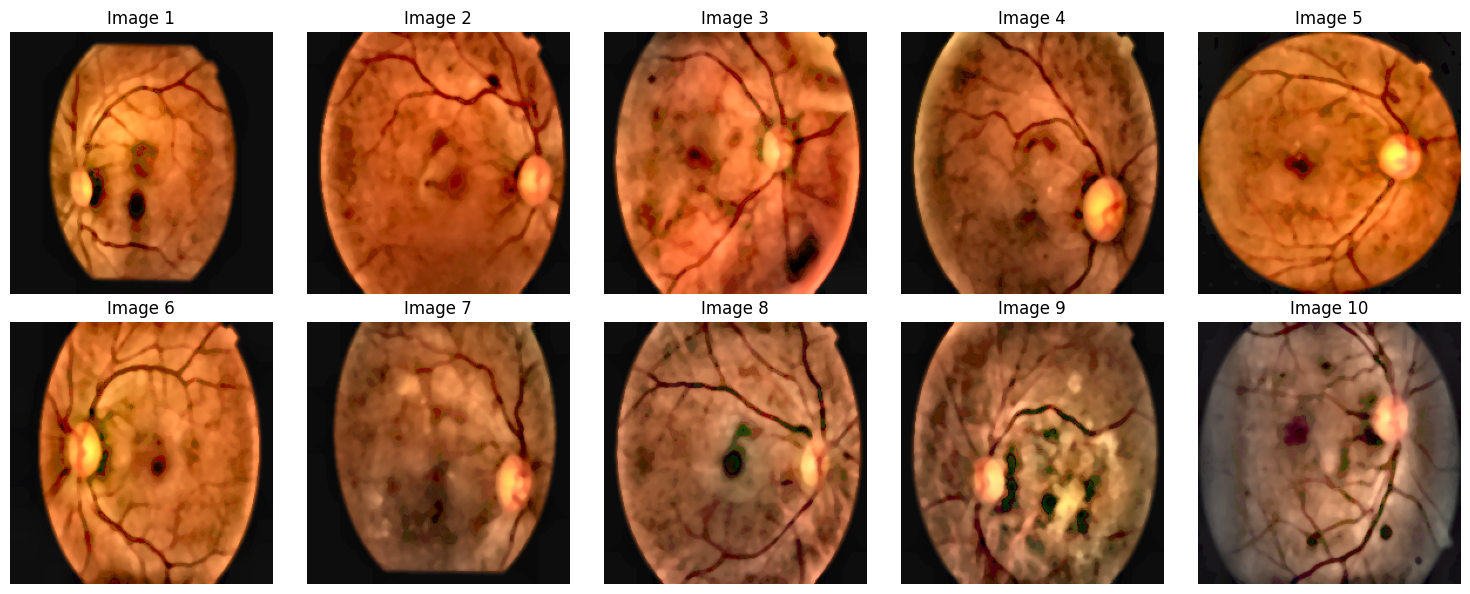

Processed image saved at: /content/drive/MyDrive/Colab Notebooks/dr_son/Mild/8bbd7835e9aa.png
Processed image saved at: /content/drive/MyDrive/Colab Notebooks/dr_son/Mild/5090917a2676.png
Processed image saved at: /content/drive/MyDrive/Colab Notebooks/dr_son/Mild/b50b30aa6e6c.png
Processed image saved at: /content/drive/MyDrive/Colab Notebooks/dr_son/Mild/3ee17aa12e46.png
Processed image saved at: /content/drive/MyDrive/Colab Notebooks/dr_son/Mild/5b0e53f53ef3.png
Processed image saved at: /content/drive/MyDrive/Colab Notebooks/dr_son/Mild/3de8ad4151e1.png
Processed image saved at: /content/drive/MyDrive/Colab Notebooks/dr_son/Mild/dd19428c3d29.png
Processed image saved at: /content/drive/MyDrive/Colab Notebooks/dr_son/Mild/0fb1053285cf.png
Processed image saved at: /content/drive/MyDrive/Colab Notebooks/dr_son/Mild/61bbe8db6f3a.png
Processed image saved at: /content/drive/MyDrive/Colab Notebooks/dr_son/Mild/6762b2b48ea5.png
Processed image saved at: /content/drive/MyDrive/Colab Noteb

In [ ]:
# Görüntü yollarını alın
image_paths = get_image_paths(img_paths)

# İşlemleri uygulayın
processed_images = process_images(image_paths)

# İşlenmiş görüntülerin ilk 10'unu görselleştirin
display_images(processed_images)

save_images_with_structure(processed_images, image_paths, img_paths, output_paths)


# Veri Arttırma İşlemleri

In [ ]:
## Veri arttırma yöntemi
train = ImageDataGenerator(
    horizontal_flip=True,       # Yatay eksende çevirme
    vertical_flip=True,         # Dikey eksende çevirme
    validation_split=0.2,       # Validation verisi için %30 ayrılacak
    rescale=1./255,             # Görüntüleri normalize etme (0-1 arası)
    shear_range=0.1,            # Kesme dönüşümü (sadece küçük oranda)
    zoom_range=(0.8, 1.0),      # Uzaklaştırma (zoom-out) işlemi, %80 ile %100 arasında uzaklaştırma
    # width_shift_range=0.1,      # Görüntüleri genişlik yönünde %10 kaydırma
    # height_shift_range=0.1,     # Görüntüleri yükseklik yönünde %10 kaydırma
    # rotation_range=10,          # Görüntüyü rastgele döndürme
    # fill_mode='nearest',        # Kaydırma sonucu oluşan boşlukları doldur
    # cval=0                      # Boş alanları siyah (0) ile doldur
)


val= ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)
test= ImageDataGenerator(
    rescale=1./255
)

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np

# Ana veri yolu ve artırılmış görüntülerin saklanacağı yol
output_paths="/content/drive/MyDrive/Colab Notebooks/dr_son" # Orijinal görüntülerin yolu
minimum_target = 1800  # Her sınıf için hedeflenen maksimum görüntü sayısı
augmented_output = "/content/drive/MyDrive/Colab Notebooks/draugsonhali"  # Artırılmış görüntülerin saklanacağı yol

# Veri artırma işlemi için ImageDataGenerator tanımı


# Artırılmış görüntülerin saklanacağı ana klasörü oluştur
if not os.path.exists(augmented_output):
    os.makedirs(augmented_output)

# Her sınıf için veri artırma işlemi
for class_dir in os.listdir(output_paths):
    class_path = os.path.join(output_paths, class_dir)

    # Klasör kontrolü
    if not os.path.isdir(class_path):
        continue

    # Yeni artırılmış görüntülerin kaydedileceği sınıf klasörü
    augmented_class_path = os.path.join(augmented_output, class_dir)
    if not os.path.exists(augmented_class_path):
        os.makedirs(augmented_class_path)  # Eksik klasörü oluştur

    # Mevcut görüntüleri ve sayısını kontrol et
    original_images = [f for f in os.listdir(class_path) if not f.startswith('.')]
    augmented_images = [f for f in os.listdir(augmented_class_path) if not f.startswith('.')]
    total_existing_images = len(original_images) + len(augmented_images)
    print(f"{class_dir} sınıfında toplam {total_existing_images} görüntü var (orijinal ).")

    # Sadece minimum hedefin altında olan sınıflar için artırma işlemi yapılır
    if total_existing_images < minimum_target:
        num_to_generate = minimum_target - total_existing_images
        print(f"{class_dir} sınıfı için {num_to_generate} yeni görüntü üretilecek.")

        generated_count = 0  # Üretilen görüntü sayısını takip et

        # Görüntüler üzerinde veri artırma işlemi
        for img_file in original_images:
            if generated_count >= num_to_generate:  # Hedeflenen görüntü sayısına ulaşıldıysa döngüyü durdur
                break

            img_path = os.path.join(class_path, img_file)
            img = load_img(img_path)  # Görüntüyü yükle
            x = img_to_array(img)  # Görüntüyü array'e çevir
            x = np.expand_dims(x, axis=0)  # 4D hale getir

            for batch in train.flow(
                x,
                batch_size=1,
                save_to_dir=augmented_class_path,
                save_prefix=os.path.splitext(img_file)[0],
                save_format='jpeg'
            ):
                generated_count += 1
                if generated_count >= num_to_generate:  # Hedeflenen görüntü sayısına ulaşıldıysa dur
                    break

        print(f"{class_dir} sınıfı için {generated_count} yeni görüntü üretildi.")
    else:
        print(f"{class_dir} sınıfı için yeterli görüntü var, veri artırma yapılmadı.")

print("Tüm veri artırma işlemleri tamamlandı!")


Mild sınıfında toplam 370 görüntü var (orijinal ).
Mild sınıfı için 1430 yeni görüntü üretilecek.
Mild sınıfı için 1430 yeni görüntü üretildi.
Moderate sınıfında toplam 999 görüntü var (orijinal ).
Moderate sınıfı için 801 yeni görüntü üretilecek.
Moderate sınıfı için 801 yeni görüntü üretildi.
Proliferate_DR sınıfında toplam 295 görüntü var (orijinal ).
Proliferate_DR sınıfı için 1505 yeni görüntü üretilecek.
Proliferate_DR sınıfı için 1505 yeni görüntü üretildi.
No_DR sınıfında toplam 1805 görüntü var (orijinal ).
No_DR sınıfı için yeterli görüntü var, veri artırma yapılmadı.
Severe sınıfında toplam 193 görüntü var (orijinal ).
Severe sınıfı için 1607 yeni görüntü üretilecek.
Severe sınıfı için 1607 yeni görüntü üretildi.
Tüm veri artırma işlemleri tamamlandı!


In [ ]:
traindata="/content/drive/MyDrive/Colab Notebooks/traindr"
testdata="/content/drive/MyDrive/Colab Notebooks/testdr"

# Modelin Hazırlanması

In [ ]:

train_generator=train.flow_from_directory(traindata, ## bu dizinde getirmesini isteriz.
                                          target_size=(224,224),
                                          batch_size=64,
                                          class_mode='categorical',  ## her bir sınıf için one hot encoding üretir. #sparche yazsaydık tek değer alır(0 1 2 3 4 5 gibi)
                                          subset='training')

validation_generator=val.flow_from_directory(traindata,
                                        target_size=(224,224),
                                        batch_size=64,
                                        class_mode='categorical',
                                        subset='validation')
test_generator = test.flow_from_directory(
    testdata,                      # Test verisi klasör yolu
    target_size=(224, 224),        # Resimleri yeniden boyutlandırma
    batch_size=64,                 # Batch boyutu
    class_mode='categorical',      # Sınıf modu (genelde 'categorical')
    shuffle=False                  # Test verisinde karıştırma yapılmaz
)

Found 5435 images belonging to 5 classes.
Found 1357 images belonging to 5 classes.
Found 1700 images belonging to 5 classes.


In [ ]:
train_images, train_labels = next(train_generator)
print("First 5 labels from the training set:")
print(train_labels[:5])

First 5 labels from the training set:
[[0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


# Predict Yapısının Hazırlanması

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing import image

# Etiketlerinizin sıralaması
dr_labels = {0: 'Mild', 1: 'Moderate', 2: 'No_DR', 3: 'Proliferate_DR', 4: 'Severe'}

# Etiketlerinizin sıralaması
dr_labels = {0: 'Mild', 1: 'Moderate', 2: 'No_DR', 3: 'Proliferate_DR', 4: 'Severe'}

# Görüntüleri yeniden boyutlandırma ve ön işleme fonksiyonu
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)  # Modelin beklediği boyuta yeniden boyutlandırma
    img_array = image.img_to_array(img) / 255.0  # Görüntüyü numpy dizisine çevirme ve normalize etme
    img_array = np.expand_dims(img_array, axis=0)  # Batch boyutunu ekleyerek şekillendirme
    return img_array

# Tahmin ve sonuçları gösterme fonksiyonu
def prediction_probs(img_array, model, labels):
    predictions = model.predict(img_array, verbose=0)  # Tahmin yapma
    predicted_class_idx = np.argmax(predictions[0])  # Tahmin edilen sınıfın index'ini al
    predicted_class = labels.get(predicted_class_idx, 'Unknown')  # Etiketle eşleştir
    max_probability = np.max(predictions[0])  # Tahmin edilen sınıfın olasılığı
    return max_probability, predicted_class

# Sonuçları Excel dosyasına kaydetme fonksiyonu
def save_results_to_excel(results, output_file="prediction_results.xlsx"):
    df = pd.DataFrame(results, columns=["Image Name", "Predicted Class", "True Class", "Probability"])
    df.to_excel(output_file, index=False)

# Rastgele görüntüleri yanyana göstermek için düzenleme fonksiyonu
def predict_and_show_results(test_directory, model, labels, num_images=20):
    results = []
    fig, axes = plt.subplots(4, 5, figsize=(15, 6))  # 4 satır 5 sütunlu bir grid
    axes = axes.ravel()  # 2D array'ı 1D array'e çevir

    img_count = 0
    all_images = []  # Tüm görüntülerin listesi
    for class_name in os.listdir(test_directory):
        class_path = os.path.join(test_directory, class_name)
        if os.path.isdir(class_path):  # Eğer bir klasörse (sınıf)
            images_in_class = [os.path.join(class_path, img_name) for img_name in os.listdir(class_path)]
            all_images.extend(images_in_class)  # Tüm sınıflardaki görüntüleri birleştir

    # Tüm görüntüler üzerinde tahmin yap ve Excel'e kaydet
    for img_path in all_images:
        img_array = preprocess_image(img_path)  # Görüntüyü ön işleme
        prob, predicted_class = prediction_probs(img_array, model, labels)  # Tahmin yap
        true_class = img_path.split(os.sep)[-2]  # Gerçek sınıf, klasör adıyla eşleşiyor

        # Sonuçları sakla
        results.append([os.path.basename(img_path), predicted_class, true_class, prob])

    # Diğer tüm sonuçları Excel'e kaydet
    save_results_to_excel(results)

    # Rastgele 'num_images' kadar görüntü seç
    random_images = random.sample(all_images, num_images)

    # 20 Görüntüyü yanyana göster
    for img_path in random_images:
        img_array = preprocess_image(img_path)  # Görüntüyü ön işleme
        prob, predicted_class = prediction_probs(img_array, model, labels)  # Tahmin yap
        true_class = img_path.split(os.sep)[-2]  # Gerçek sınıf, klasör adıyla eşleşiyor

        # Görüntüyü yanyana göster
        axes[img_count].imshow(image.load_img(img_path))
        axes[img_count].set_title(f"Pred: {predicted_class}\nTrue: {true_class}\nProb: {prob:.2f}")
        axes[img_count].axis('off')  # Ekseni kapatma
        img_count += 1

    plt.tight_layout()
    plt.show()

# Karmaşıklık matrisini oluşturma ve görselleştirme fonksiyonu
def generate_confusion_matrix(test_directory, model, labels):
    y_true = []
    y_pred = []

    # Test klasöründeki tüm görüntüleri dolaş
    for class_name in os.listdir(test_directory):
        class_path = os.path.join(test_directory, class_name)
        if os.path.isdir(class_path):  # Eğer bir klasörse (sınıf)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img_array = preprocess_image(img_path)  # Görüntüyü ön işleme

                # Modelin tahminlerini al
                prob, predicted_class = prediction_probs(img_array, model, labels)
                predicted_class_idx = list(labels.values()).index(predicted_class)
                true_class_idx = list(labels.values()).index(class_name)

                # Gerçek ve tahmin edilen sınıfları listeye ekle
                y_true.append(true_class_idx)
                y_pred.append(predicted_class_idx)

    # Karmaşıklık matrisini hesapla
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=list(labels.values()), yticklabels=list(labels.values()))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


# Kendi CNN modelimiz

In [ ]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Dropout, BatchNormalization, GlobalAveragePooling2D

model_cnn1 = Sequential([
    layers.Input(shape=(224, 224, 3)),

    # 1. Katman
    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.2),

    # 2. Katman
    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.2),

    # 3. Katman
    layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.2),

    # 4. Katman
    layers.Conv2D(256, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.3),

    # 5. Katman
    layers.Conv2D(512, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.4),
#
     # 6. Katman
    layers.Conv2D(1024, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.3),

    # flatten
    layers.Flatten(),

    # Tam Bağlantılı Katman
    layers.Dense(2048, activation="relu"),
    BatchNormalization(),
    Dropout(0.4),

    # Çıkış Katmanı
    layers.Dense(5, activation="softmax")
])

model_cnn1.summary()



metrics = [
    "accuracy",
    AUC(name='auc', multi_label=True),
    Precision(name='precision'),
    Recall(name='recall')
]


model_cnn1.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=metrics
)

early_stopping_cnn1 = EarlyStopping(monitor='val_loss',
                           patience=20,
                           verbose=1,
                           restore_best_weights=True,
                                   mode="min")

model_checkpoint_cnn1= ModelCheckpoint(filepath='/content/drive/My Drive/my_model_cnn_dr1.keras',
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1)

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_reduction1 = ReduceLROnPlateau(
    monitor='val_loss',    # İzlenecek metrik
    patience=3,            # Kaç epoch boyunca iyileşme olmadığında devreye girecek
    verbose=1,             # Detaylı çıktı için
    mode='min',           # Metrik 'min' veya 'max' modunda otomatik seçilecek
    factor=0.25,           # Öğrenme oranını bu faktörle çarpacak
    min_lr=0.000001        # Öğrenme oranının düşebileceği minimum değer
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 7, 7, 1024)          │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 3, 3, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 3, 3, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │      18,876,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │              

 Total params: 25,183,045 (96.07 MB)

 Trainable params: 25,178,949 (96.05 MB)

 Non-trainable params: 4,096 (16.00 KB)

In [ ]:
start_time = datetime.datetime.now()

history1 = model_cnn1.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping_cnn1, model_checkpoint_cnn1,lr_reduction1])

end_time = datetime.datetime.now()
total_duration = end_time - start_time
print("Trainin Time:", total_duration)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


84/85 ━━━━━━━━━━━━━━━━━━━━ 40s 40s/step - accuracy: 0.5107 - auc: 0.7627 - loss: 1.6412 - precision: 0.5543 - recall: 0.4543 
Epoch 1: val_loss improved from inf to 0.79848, saving model to /content/drive/My Drive/my_model_cnn_dr1.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 4649s 51s/step - accuracy: 0.5136 - auc: 0.7648 - loss: 1.6306 - precision: 0.5573 - recall: 0.4573 - val_accuracy: 0.7863 - val_auc: 0.9322 - val_loss: 0.7985 - val_precision: 0.8518 - val_recall: 0.7413 - learning_rate: 0.0010
Epoch 2/100
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.7840 - auc: 0.9391 - loss: 0.6689 - precision: 0.8154 - recall: 0.7567
Epoch 2: val_loss did not improve from 0.79848
85/85 ━━━━━━━━━━━━━━━━━━━━ 76s 825ms/step - accuracy: 0.7843 - auc: 0.9392 - loss: 0.6683 - precision: 0.8157 - recall: 0.7570 - val_accuracy: 0.5608 - val_auc: 0.9222 - val_loss: 1.1268 - val_precision: 0.6815 - val_recall: 0.4967 - learning_rate: 0.0010
Epoch 3/100
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0

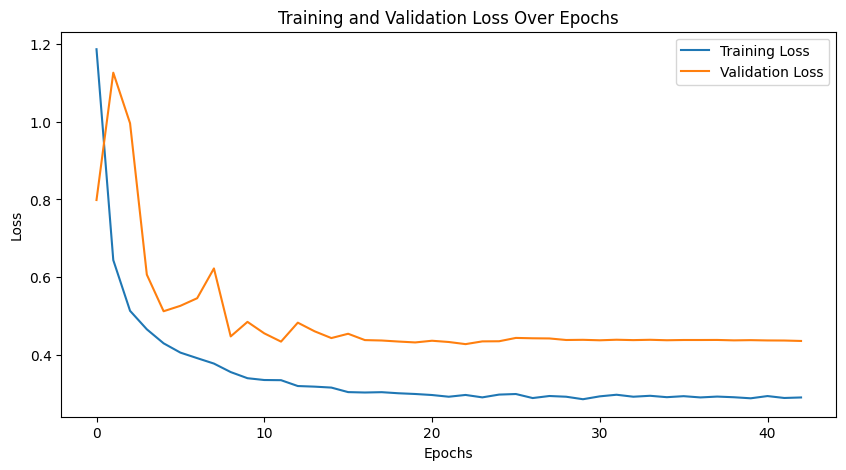

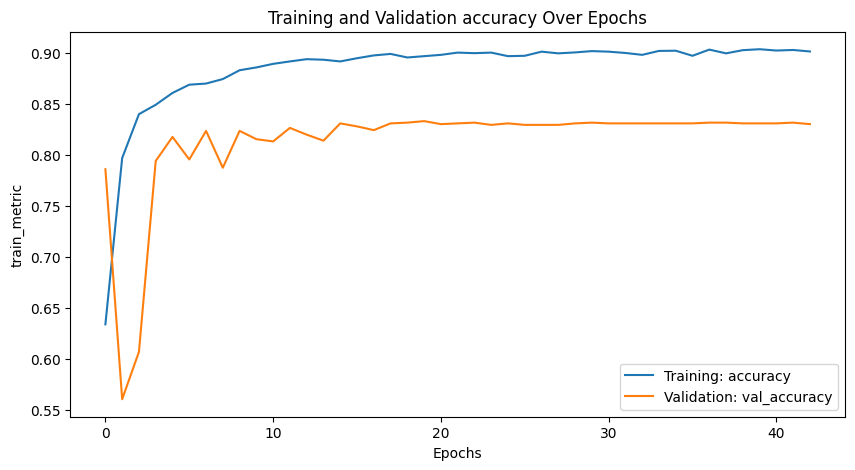

In [ ]:
plot_training_history(history1, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy')

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_auc = model_cnn1.evaluate(test_generator, verbose=0)
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print(f"Loss: {test_loss}")
print(f" Accuracy: {test_accuracy}")
print(f" AUC: {test_auc}")
print(f" Precision: {test_precision}")
print(f" Recall: {test_recall}")
predict_and_show_results(testdata, model_cnn, dr_labels)  # Sonuçları göster
generate_confusion_matrix(testdata, model_cnn, dr_labels)  # Karmaşıklık matrisini oluştur
print(f" F1-Score: {f1_score}")

Loss: 0.31815049052238464
 Accuracy: 0.8899999856948853
 AUC: 0.8841176629066467
 Precision: 0.9928275942802429
 Recall: 0.8994613885879517
 F1-Score: 0.9438411306778131


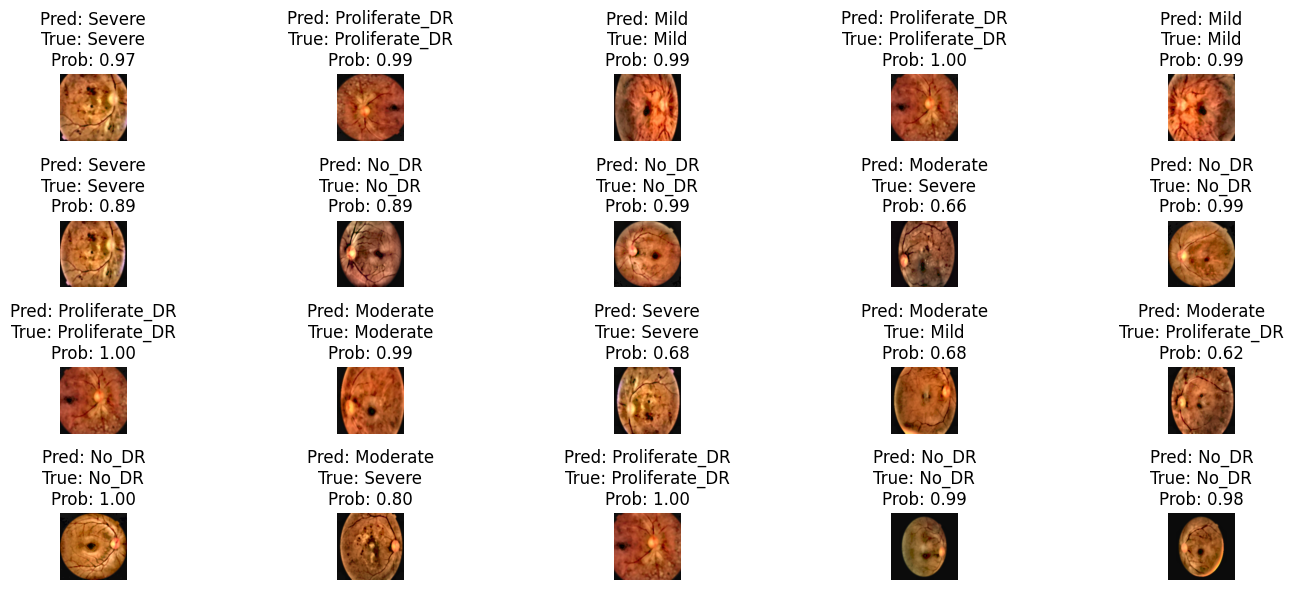

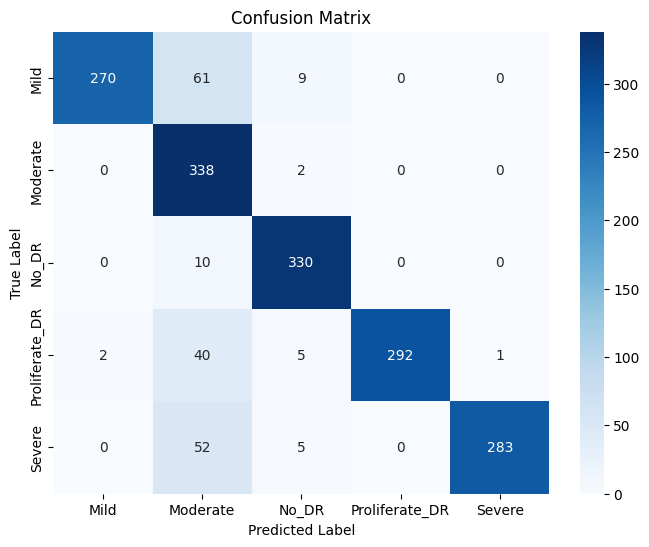

In [ ]:

predict_and_show_results(testdata, model_cnn1, dr_labels)  # Sonuçları göster
generate_confusion_matrix(testdata, model_cnn1, dr_labels)  # Karmaşıklık matrisini oluştur

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, AUC
# model_cnn= Sequential([
#     layers.Input(shape=(224,224,3)),

#     layers.Conv2D(16,(3,3),activation="relu"),  #Evrişim katmanı-Özellik Çıkarır. ##32 tane 3,3 kernel ekle
#     # layers.Conv2D(16,(3,3),activation="relu"),
#     layers.MaxPooling2D((2,2)),  # Pooling katmanı - özellik haritasının boyutunu küçültür hesaplama maliyetini düşürür.
#     Dropout(0.2),


#     layers.Conv2D(32,(3,3),activation="relu"),  #Evrişim katmanı-Özellik Çıkarır. ##32 tane 3,3 kernel ekle
#     # layers.Conv2D(32,(3,3),activation="relu"),
#     layers.MaxPooling2D((2,2)),  # Pooling katmanı - özellik haritasının boyutunu küçültür hesaplama maliyetini düşürür.
#     Dropout(0.3),

#     layers.Conv2D(64,(3,3),activation="relu"),
#     # layers.Conv2D(64,(3,3),activation="relu"),
#     layers.MaxPooling2D((2,2)),
#     Dropout(0.2),

#     layers.Conv2D(128,(3,3),activation="relu"),
#     # layers.Conv2D(128,(3,3),activation="relu"),
#     layers.MaxPooling2D((2,2)),
#     Dropout(0.3),


#     layers.Conv2D(256,(3,3),activation="relu"),
#     # layers.Conv2D(256,(3,3),activation="relu"),
#     layers.MaxPooling2D((2,2)),
#     Dropout(0.2),

#     layers.Conv2D(512,(3,3),activation="relu"),
#     # layers.Conv2D(256,(3,3),activation="relu"),
#     layers.MaxPooling2D((2,2)),
#     Dropout(0.2),

#     layers.Flatten(),
#     layers.Dense(1024,activation="relu"), ##Tam bağımlı katman  --> özelliklerin ağırlıklarını öğrenir. 256 tane nöron vardır.
#     BatchNormalization(),
#     Dropout(0.3),
#     layers.Dense(5,activation="softmax")
# ])

from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Dropout, BatchNormalization, GlobalAveragePooling2D

model_cnn = Sequential([
    layers.Input(shape=(224, 224, 3)),

    # 1. Katman
    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.2),

    # 2. Katman
    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.2),

    # 3. Katman
    layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.2),

    # 4. Katman
    layers.Conv2D(256, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.3),

    # 5. Katman
    layers.Conv2D(512, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.3),
#
     # 6. Katman
    layers.Conv2D(1024, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.3),

    # 7. Katman
    layers.Conv2D(2048, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.4),


    # flatten
    layers.Flatten(),

    # Tam Bağlantılı Katman
    layers.Dense(4096, activation="relu"),
    BatchNormalization(),
    Dropout(0.4),

    # Çıkış Katmanı
    layers.Dense(5, activation="softmax")
])

model_cnn.summary()



metrics = [
    "accuracy",
    AUC(name='auc', multi_label=True),
    Precision(name='precision'),
    Recall(name='recall')
]


model_cnn.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=metrics
)

early_stopping_cnn = EarlyStopping(monitor='val_loss',
                           patience=20,
                           verbose=1,
                           restore_best_weights=True,
                                   mode="min")

model_checkpoint_cnn= ModelCheckpoint(filepath='/content/drive/My Drive/my_model_cnn_dr.keras',
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1)

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',    # İzlenecek metrik
    patience=3,            # Kaç epoch boyunca iyileşme olmadığında devreye girecek
    verbose=1,             # Detaylı çıktı için
    mode='min',           # Metrik 'min' veya 'max' modunda otomatik seçilecek
    factor=0.25,           # Öğrenme oranını bu faktörle çarpacak
    min_lr=0.000001        # Öğrenme oranının düşebileceği minimum değer
)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 14, 14, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 7, 7, 1024)          │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 3, 3, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 3, 3, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 3, 3, 2048)          │      18,876,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 1, 1, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 1, 1, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 33,594,181 (128.15 MB)

 Trainable params: 33,585,989 (128.12 MB)

 Non-trainable params: 8,192 (32.00 KB)

In [ ]:
start_time = datetime.datetime.now()

history = model_cnn.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping_cnn, model_checkpoint_cnn,lr_reduction])

end_time = datetime.datetime.now()
total_duration = end_time - start_time
print("Trainin Time:", total_duration)

Epoch 1/100
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - accuracy: 0.3240 - auc: 0.6397 - loss: 2.5191 - precision: 0.3449 - recall: 0.2583
Epoch 1: val_loss improved from inf to 2.62707, saving model to /content/drive/My Drive/my_model_cnn_dr.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 93s 893ms/step - accuracy: 0.3257 - auc: 0.6411 - loss: 2.5059 - precision: 0.3473 - recall: 0.2589 - val_accuracy: 0.1997 - val_auc: 0.6693 - val_loss: 2.6271 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.6429 - auc: 0.8715 - loss: 1.0133 - precision: 0.7158 - recall: 0.5585
Epoch 2: val_loss improved from 2.62707 to 0.84927, saving model to /content/drive/My Drive/my_model_cnn_dr.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 76s 810ms/step - accuracy: 0.6444 - auc: 0.8723 - loss: 1.0096 - precision: 0.7170 - recall: 0.5605 - val_accuracy: 0.6566 - val_auc: 0.9358 - val_loss: 0.8493 - val_precision: 0.6933 - val_recall: 0.5682 - le

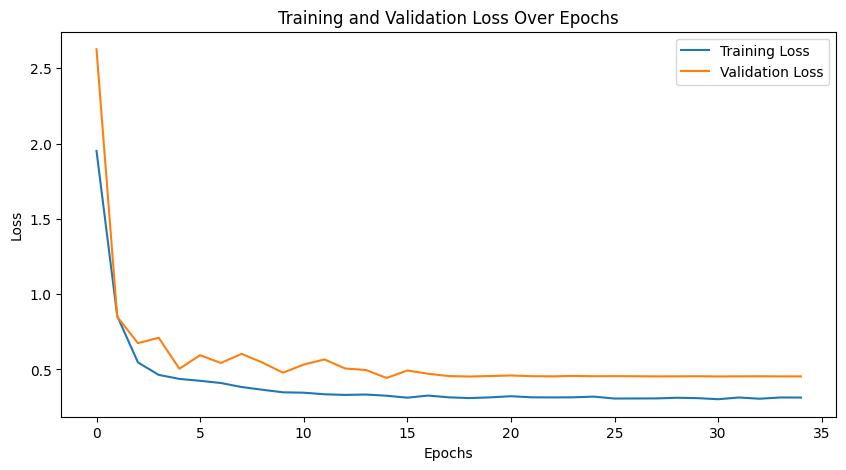

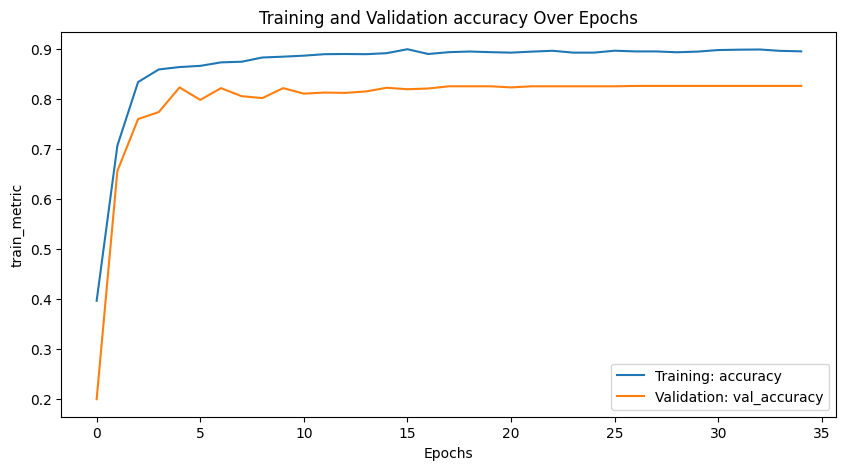

In [ ]:
plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy')

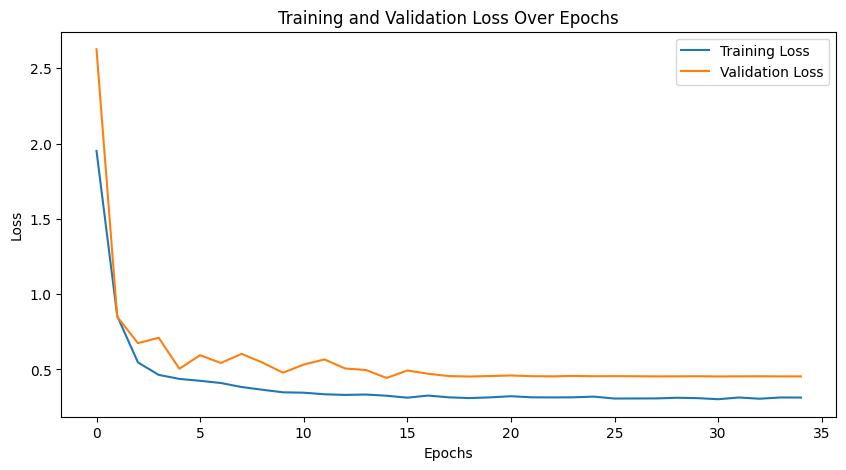

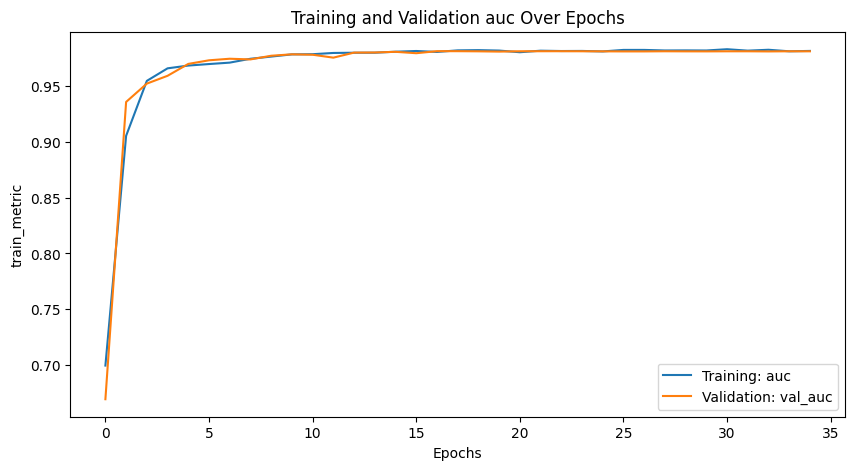

In [ ]:
plot_training_history(history, train_loss='loss', train_metric='auc', val_loss='val_loss', val_metric='val_auc')

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_auc = model_cnn.evaluate(test_generator, verbose=0)


In [ ]:
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print(f"Loss: {test_loss}")
print(f" Accuracy: {test_accuracy}")
print(f" AUC: {test_auc}")
print(f" Precision: {test_precision}")
print(f" Recall: {test_recall}")
print(f" F1-Score: {f1_score}")

Loss: 0.3156198561191559
 Accuracy: 0.8782352805137634
 AUC: 0.8670588135719299
 Precision: 0.991862416267395
 Recall: 0.8911728858947754
 F1-Score: 0.9388256193610698


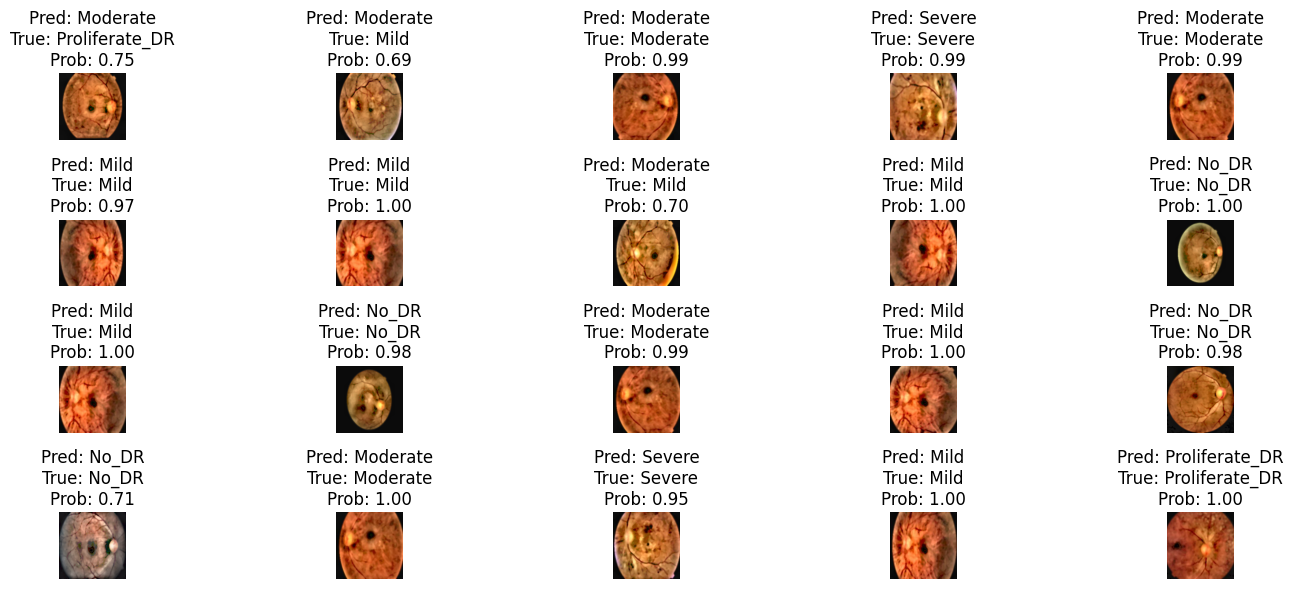

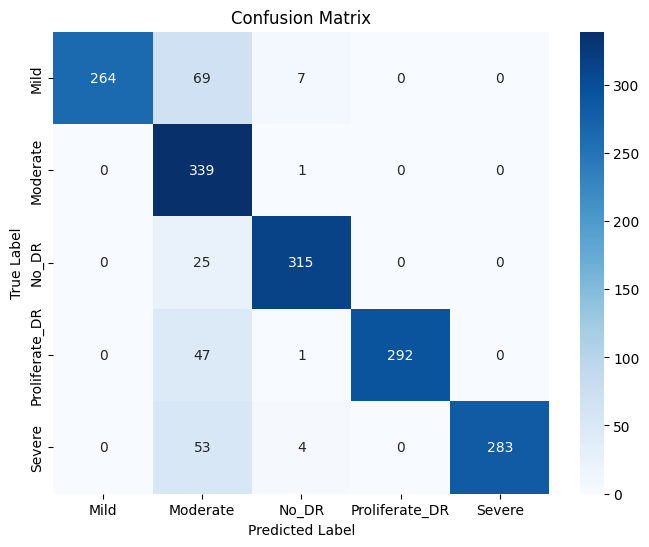

In [ ]:

predict_and_show_results(testdata, model_cnn, dr_labels)  # Sonuçları göster
generate_confusion_matrix(testdata, model_cnn, dr_labels)  # Karmaşıklık matrisini oluştur

# EfficientNetB0


In [ ]:

modelefficient=Sequential()

modelefficient.add(EfficientNetB0(weights='imagenet',include_top=False,input_shape=(224,224,3)))
modelefficient.add(layers.GlobalAveragePooling2D())
modelefficient.add(layers.Dropout(0.5))
modelefficient.add(layers.Dense(1024,activation="relu"))
modelefficient.add(layers.Dense(5,activation="softmax"))
modelefficient.summary()

metrics = [
    "accuracy",
    AUC(name='auc', multi_label=True),
    Precision(name='precision'),
    Recall(name='recall')
]


modelefficient.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=metrics
)


early_stopping = EarlyStopping(monitor='val_loss',
                           patience=20,
                           verbose=1,
                           restore_best_weights=True,
                               mode="min")

model_checkpoint= ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/Diyabetik Retinopati/my_model_eff_dr.keras',
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1)


lr_reduction_eff = ReduceLROnPlateau(
    monitor='val_loss',    # İzlenecek metrik
    patience=3,            # Kaç epoch boyunca iyileşme olmadığında devreye girecek
    verbose=1,             # Detaylı çıktı için
    mode='min',           # Metrik 'min' veya 'max' modunda otomatik seçilecek
    factor=0.25,           # Öğrenme oranını bu faktörle çarpacak
    min_lr=0.000001        # Öğrenme oranının düşebileceği minimum değer
)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 5)                   │           5,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,366,440 (20.47 MB)

 Trainable params: 5,324,417 (20.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
start_time = datetime.datetime.now()

efficient = modelefficient.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping, model_checkpoint,lr_reduction_eff])

end_time = datetime.datetime.now()
total_duration = end_time - start_time
print("Trainin Time:", total_duration)

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8371 - auc: 0.9532 - loss: 0.5129 - precision: 0.8991 - recall: 0.7476
Epoch 1: val_loss improved from inf to 2.47302, saving model to /content/drive/MyDrive/Colab Notebooks/Diyabetik Retinopati/my_model_eff_dr.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.8375 - auc: 0.9535 - loss: 0.5115 - precision: 0.8992 - recall: 0.7485 - val_accuracy: 0.2159 - val_auc: 0.4862 - val_loss: 2.4730 - val_precision: 0.2159 - val_recall: 0.2159 - learning_rate: 0.0010
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.8947 - auc: 0.9827 - loss: 0.3045 - precision: 0.9141 - recall: 0.8729
Epoch 2: val_loss improved from 2.47302 to 2.41123, saving model to /content/drive/MyDrive/Colab Notebooks/Diyabetik Retinopati/my_model_eff_dr.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 74s 805ms/step - accuracy: 0.8947 - auc: 0.9827 - loss: 0.3044 - precision: 0.9142 - recall: 0.8729 - val_accuracy: 0.1909 - val_auc: 0.4703 - val_los

In [ ]:
test_loss, test_accuracy, test_precision, test_recall,test_auc = modelefficient.evaluate(test_generator, verbose=0)
f1_score = 2 * (test_precision *test_recall) / (test_precision + test_recall)
print(f" Loss: {test_loss}")
print(f" Accuracy: {test_accuracy}")
print(f" AUC: {test_auc}")
print(f" Precision: {test_precision}")
print(f" Recall: {test_recall}")
print(f" F1-Score: {f1_score}")

 Loss: 0.25657525658607483
 Accuracy: 0.9241176247596741
 AUC: 0.9217647314071655
 Precision: 0.9912093281745911
 Recall: 0.9272189140319824
 F1-Score: 0.9581469002888577


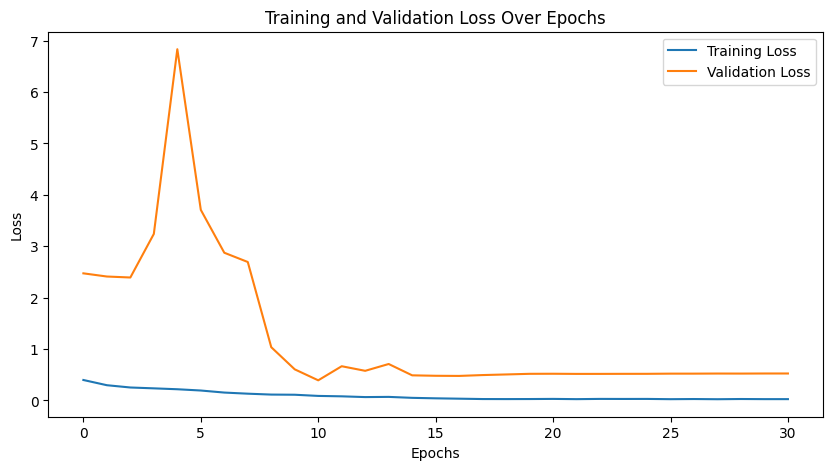

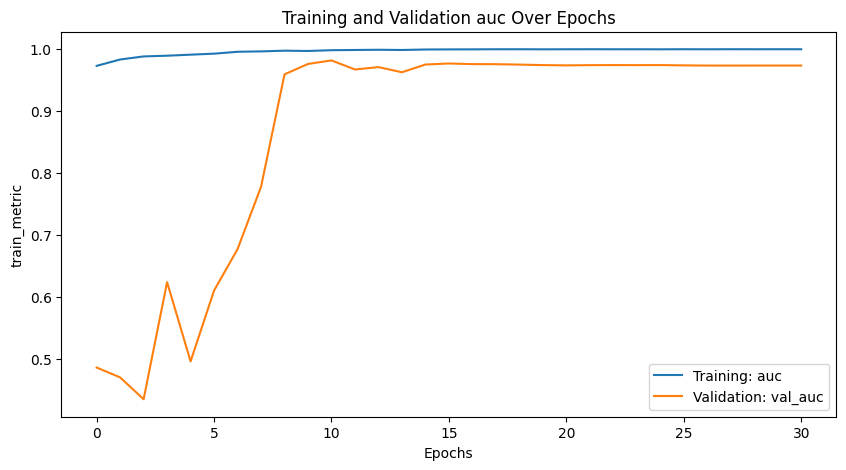

In [ ]:
plot_training_history(efficient, train_loss='loss', train_metric='auc', val_loss='val_loss', val_metric='val_auc')

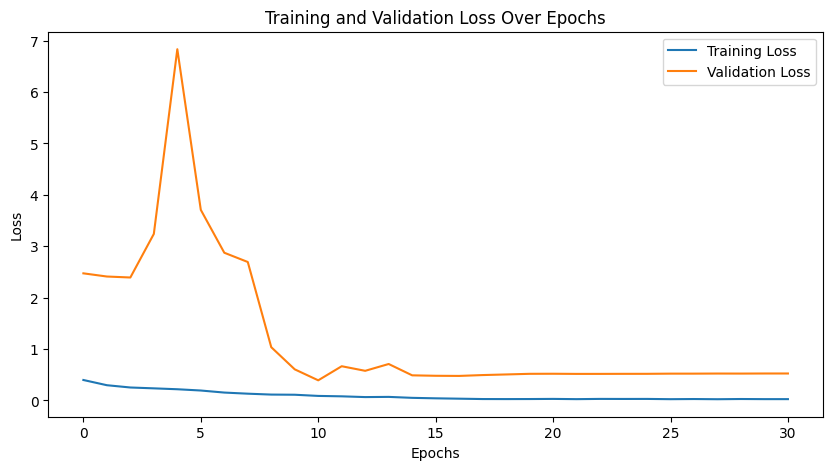

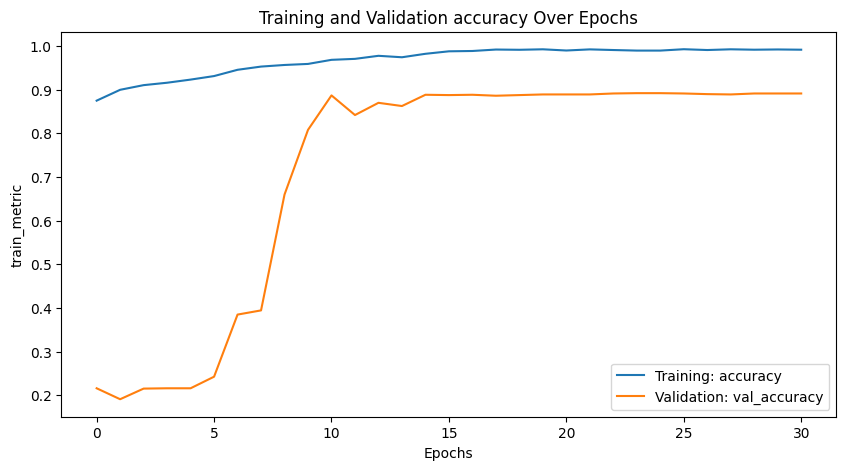

In [ ]:
plot_training_history(efficient, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy')

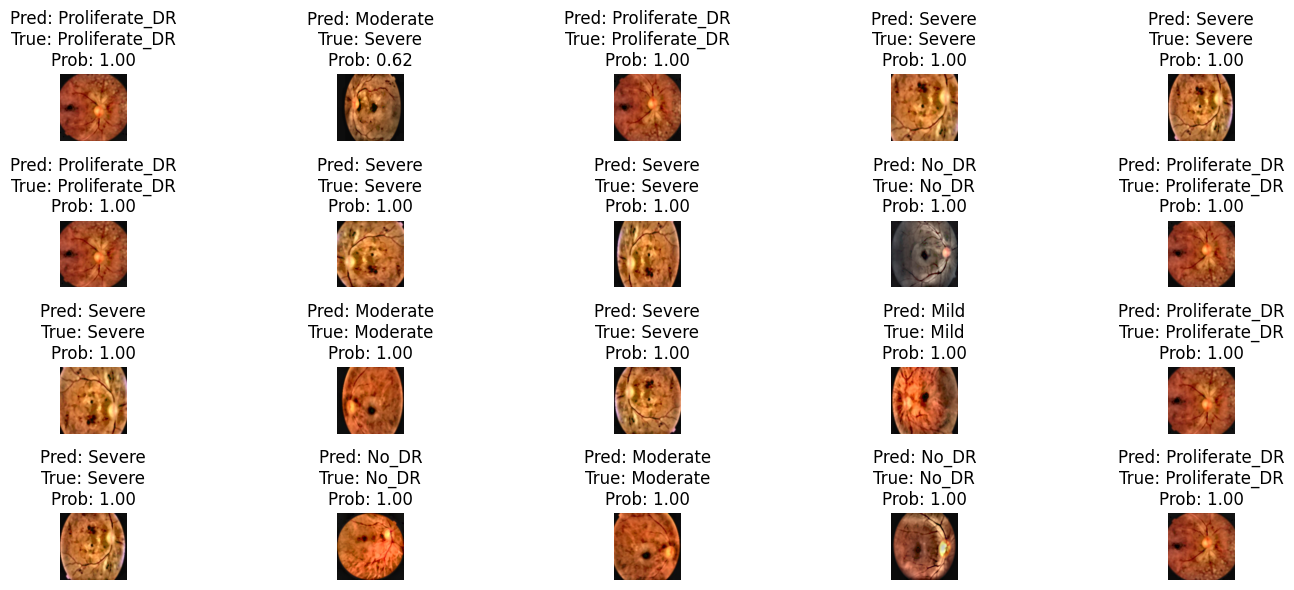

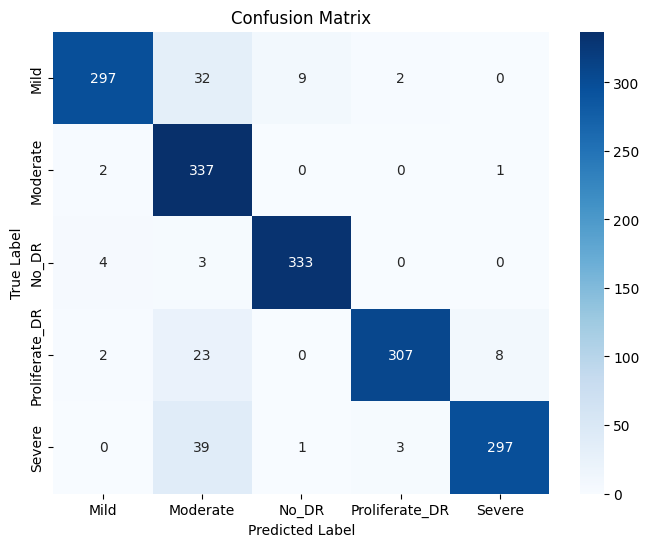

In [ ]:
# modeleff=load_model("/content/drive/MyDrive/Colab Notebooks/Diyabetik Retinopati/my_model_eff.keras")
predict_and_show_results(testdata,  modelefficient, dr_labels)

generate_confusion_matrix(testdata, modelefficient, dr_labels)  # Karmaşıklık matrisini oluştur




# AlexNet


In [ ]:


# AlexNet tarzında model oluşturma
modelalexnet = Sequential()
modelalexnet.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)))
modelalexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
modelalexnet.add(Conv2D(256, kernel_size=(5, 5), activation='relu', padding='same'))
modelalexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
modelalexnet.add(Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'))
modelalexnet.add(Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'))
modelalexnet.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
modelalexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
modelalexnet.add(Flatten())
modelalexnet.add(Dense(4096, activation='relu'))
modelalexnet.add(Dropout(0.5))
modelalexnet.add(Dense(4096, activation='relu'))
modelalexnet.add(Dropout(0.5))
modelalexnet.add(Dense(5, activation='softmax'))

#metrics


metrics = [
    "accuracy",
    AUC(name='auc', multi_label=True),
    Precision(name='precision'),
    Recall(name='recall')
]

# Modeli derleme
modelalexnet.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=metrics
)

# Model özeti
modelalexnet.summary()



early_stopping_alexnet = EarlyStopping(monitor='val_loss',
                           patience=20,
                           verbose=1,
                           restore_best_weights=True,
                               mode="min")

model_checkpoint_alexnet= ModelCheckpoint(filepath='my_model_alexnet_dr.keras',
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1)


lr_reduction_alexnet = ReduceLROnPlateau(
    monitor='val_loss',    # İzlenecek metrik
    patience=3,            # Kaç epoch boyunca iyileşme olmadığında devreye girecek
    verbose=1,             # Detaylı çıktı için
    mode='min',           # Metrik 'min' veya 'max' modunda otomatik seçilecek
    factor=0.25,           # Öğrenme oranını bu faktörle çarpacak
    min_lr=0.000001        # Öğrenme oranının düşebileceği minimum değer
)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)                   │ (None, 54, 54, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 26, 26, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 26, 26, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 12, 12, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 12, 12, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 12, 12, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 4096)                │      26,218,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 5)                   │          20,485 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,767,493 (178.40 MB)

 Trainable params: 46,767,493 (178.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
start_time_alexnet = datetime.datetime.now()

alexnet = modelalexnet.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping_alexnet, model_checkpoint_alexnet,lr_reduction_alexnet])

end_time_alexnet = datetime.datetime.now()
total_duration_alexnet = end_time_alexnet - start_time_alexnet
print("Trainin Time:", total_duration_alexnet)

Epoch 1/100
83/85 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step - accuracy: 0.3454 - auc: 0.6535 - loss: 1.4720 - precision: 0.4602 - recall: 0.0594
Epoch 1: val_loss improved from inf to 0.91134, saving model to my_model_alexnet_dr.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 99s 992ms/step - accuracy: 0.3506 - auc: 0.6582 - loss: 1.4635 - precision: 0.4736 - recall: 0.0652 - val_accuracy: 0.7266 - val_auc: 0.9210 - val_loss: 0.9113 - val_precision: 0.8638 - val_recall: 0.5564 - learning_rate: 5.0000e-05
Epoch 2/100
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - accuracy: 0.7796 - auc: 0.9392 - loss: 0.6575 - precision: 0.8720 - recall: 0.6780
Epoch 2: val_loss improved from 0.91134 to 0.62149, saving model to my_model_alexnet_dr.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 76s 824ms/step - accuracy: 0.7800 - auc: 0.9394 - loss: 0.6563 - precision: 0.8721 - recall: 0.6789 - val_accuracy: 0.8128 - val_auc: 0.9452 - val_loss: 0.6215 - val_precision: 0.8595 - val_recall: 0.7664 - learning_rate: 5.0000e-05
Epoch 3/100
84/85 ━━

In [ ]:
test_loss, test_accuracy, test_precision, test_recall,test_auc = modelalexnet.evaluate(test_generator, verbose=0)
f1_score = 2 * (test_precision *test_recall) / (test_precision + test_recall)
print(f" Loss: {test_loss}")
print(f" Accuracy: {test_accuracy}")
print(f" AUC: {test_auc}")
print(f" Precision: {test_precision}")
print(f" Recall: {test_recall}")
print(f" F1-Score: {f1_score}")

 Loss: 0.32156774401664734
 Accuracy: 0.8876470327377319
 AUC: 0.8829411864280701
 Precision: 0.9887555241584778
 Recall: 0.901501476764679
 F1-Score: 0.9431146820276614


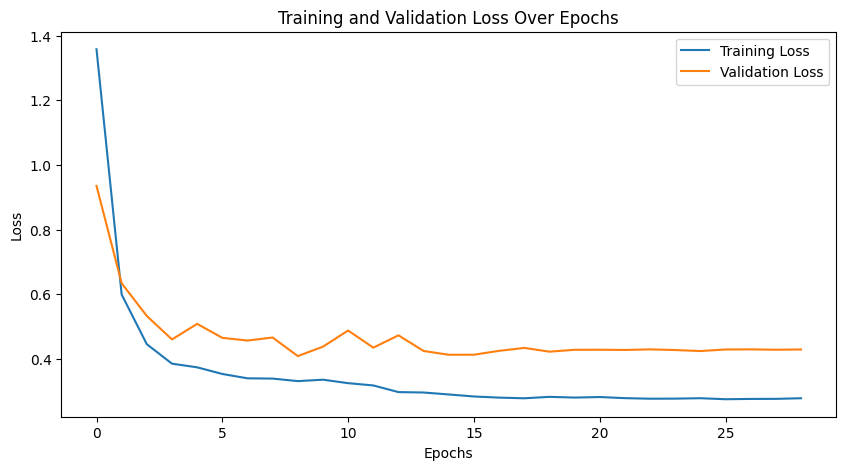

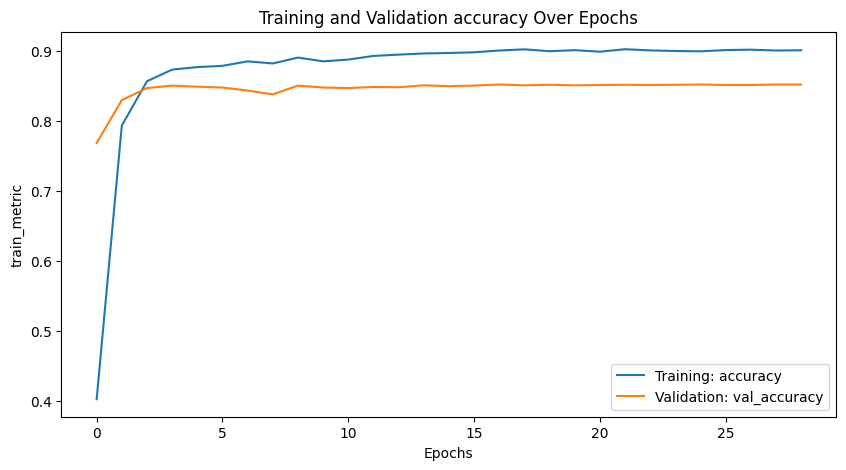

In [ ]:
plot_training_history(alexnet, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy')

In [ ]:

alexnet=load_model("/content/drive/MyDrive/Colab Notebooks/Tubitak/my_model_alexnet.keras")

# Tahminleri yap ve rastgele 20 görüntüyü göster
predict_and_show_results(testdata, alexnet, dr_labels)


# Resnet

In [ ]:
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.metrics import AUC

# # ResNet50 modelini yükleyip son katmanı hariç tutuyoruz
# resnet_backbone = ResNet50(weights='imagenet',
#                            include_top=False,
#                            input_shape=(224, 224, 3))

# # Sadece son katmanı değiştireceğiz, diğer katmanları donduruyoruz
# for layer in resnet_backbone.layers:
#     layer.trainable = False

# # Yeni son katmanı ekliyoruz
# x = GlobalAveragePooling2D()(resnet_backbone.output)
# x = Dense(5, activation='softmax')(x)  # 6 sınıf için son katman

# # Yeni modeli oluşturuyoruz
# modelresnet = Model(inputs=resnet_backbone.input, outputs=x)

# # Modeli derliyoruz
# metrics = ["accuracy", AUC(name='auc', multi_label=True)]
# optimizer=Adam(learning_rate=0.00005)
# modelresnet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)


# early_stopping_resnet = EarlyStopping(monitor='val_loss',
#                            patience=20,
#                            verbose=1,
#                            restore_best_weights=True,
#                                mode="min")

# model_checkpoint_resnet= ModelCheckpoint(filepath='my_model_resnet.keras',
#                              monitor='val_loss',
#                              save_best_only=True,
#                              save_weights_only=False,
#                              verbose=1)


# lr_reduction_resnet= ReduceLROnPlateau(
#     monitor='val_loss',    # İzlenecek metrik
#     patience=3,            # Kaç epoch boyunca iyileşme olmadığında devreye girecek
#     verbose=1,             # Detaylı çıktı için
#     mode='min',           # Metrik 'min' veya 'max' modunda otomatik seçilecek
#     factor=0.25,           # Öğrenme oranını bu faktörle çarpacak
#     min_lr=0.000001        # Öğrenme oranının düşebileceği minimum değer
# )


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam,SGD


# ResNet50 tabanlı model oluşturma
modelresnet = Sequential()

metrics = [
    "accuracy",
    AUC(name='auc', multi_label=True),
    Precision(name='precision'),
    Recall(name='recall')
]


modelresnet.add(ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
modelresnet.add(GlobalAveragePooling2D())
modelresnet.add(Dropout(0.5))
modelresnet.add(Dense(1024, activation="relu"))
modelresnet.add(Dense(5, activation="softmax"))

# Modeli derleme
modelresnet.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=metrics
)

# Model özeti
modelresnet.summary()



early_stopping_resnet = EarlyStopping(monitor='val_loss',
                           patience=20,
                           verbose=1,
                           restore_best_weights=True,
                               mode="min")

model_checkpoint_resnet= ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/Tubitak/my_model_resnet_dr.keras',
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1)


lr_reduction_resnet= ReduceLROnPlateau(
    monitor='val_loss',    # İzlenecek metrik
    patience=3,            # Kaç epoch boyunca iyileşme olmadığında devreye girecek
    verbose=1,             # Detaylı çıktı için
    mode='min',           # Metrik 'min' veya 'max' modunda otomatik seçilecek
    factor=0.25,           # Öğrenme oranını bu faktörle çarpacak
    min_lr=0.000001        # Öğrenme oranının düşebileceği minimum değer
)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 5)                   │           5,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,691,013 (98.00 MB)

 Trainable params: 25,637,893 (97.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
start_time_resnet = datetime.datetime.now()

resnet = modelresnet.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping_resnet, model_checkpoint_resnet,lr_reduction_resnet])

end_time_resnet = datetime.datetime.now()
total_duration_resnet = end_time_resnet - start_time_resnet
print("Trainin Time:", total_duration_resnet)

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7806 - auc: 0.9190 - loss: 0.8655 - precision: 0.8414 - recall: 0.6835
Epoch 1: val_loss improved from inf to 9322.35254, saving model to my_model_resnet_dr.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.7813 - auc: 0.9194 - loss: 0.8623 - precision: 0.8419 - recall: 0.6846 - val_accuracy: 0.1938 - val_auc: 0.5018 - val_loss: 9322.3525 - val_precision: 0.1938 - val_recall: 0.1938 - learning_rate: 0.0010
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.8805 - auc: 0.9741 - loss: 0.3891 - precision: 0.9138 - recall: 0.8376
Epoch 2: val_loss improved from 9322.35254 to 3.21011, saving model to my_model_resnet_dr.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 75s 821ms/step - accuracy: 0.8805 - auc: 0.9742 - loss: 0.3888 - precision: 0.9138 - recall: 0.8377 - val_accuracy: 0.2159 - val_auc: 0.5244 - val_loss: 3.2101 - val_precision: 0.2159 - val_recall: 0.2159 - learning_rate: 0.0010
Epoch 3/100
85/85 ━━━━━━━━

In [ ]:
test_loss, test_accuracy, test_precision, test_recall,test_auc = modelresnet.evaluate(test_generator, verbose=0)
f1_score = 2 * (test_precision *test_recall) / (test_precision + test_recall)
print(f" Loss: {test_loss}")
print(f" Accuracy: {test_accuracy}")
print(f" AUC: {test_auc}")
print(f" Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f" F1-Score: {f1_score}")

 Loss: 0.22058868408203125
 Accuracy: 0.9117646813392639
 AUC: 0.8999999761581421
 Precision: 0.9949104189872742
Recall: 0.928398072719574
 F1-Score: 0.9605041723667448


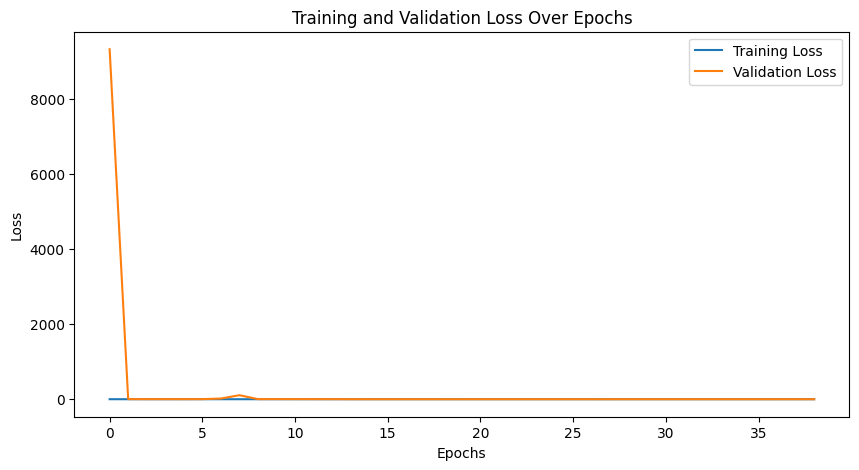

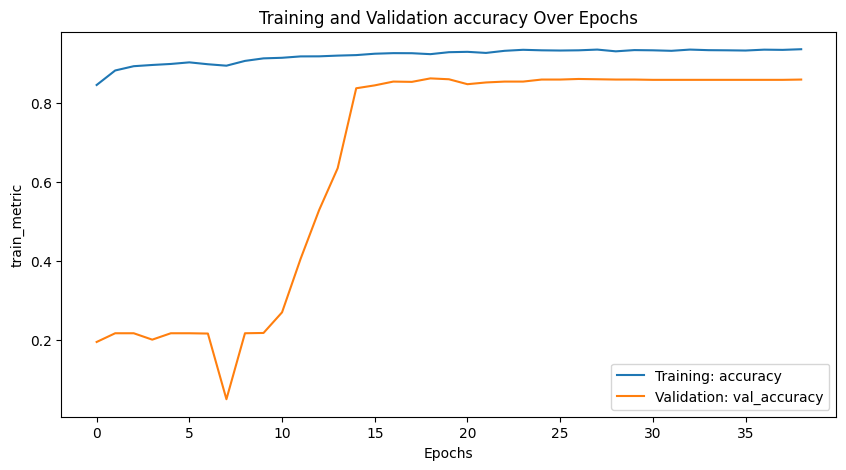

In [ ]:
plot_training_history(resnet, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy')

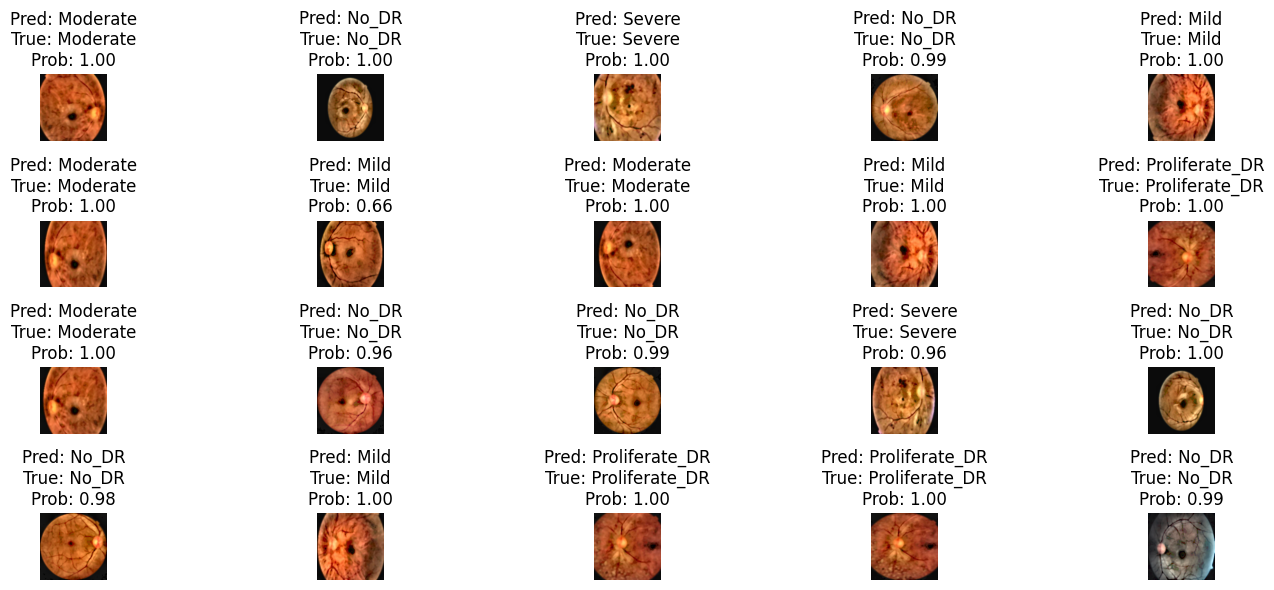

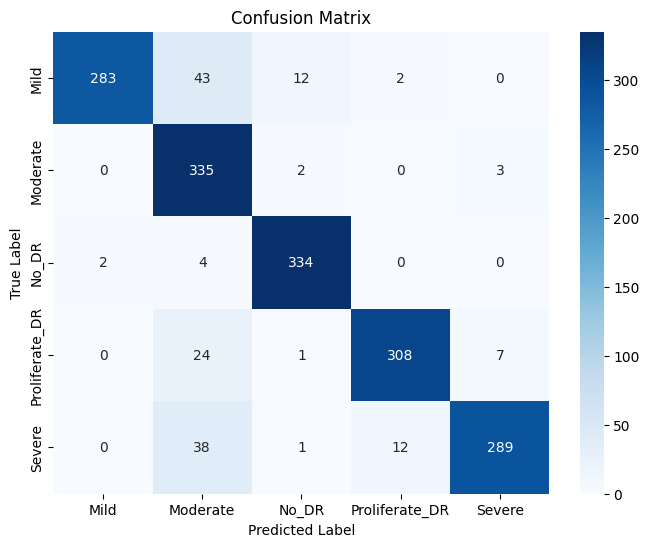

In [ ]:
modelres=load_model("//content/drive/MyDrive/Colab Notebooks/Diyabetik Retinopati/my_model_resnet_dr.keras")
predict_and_show_results(testdata, modelres, dr_labels)

generate_confusion_matrix(testdata, modelres, dr_labels)  # Karmaşıklık matrisini oluştur

#xception

In [ ]:

metrics = [
    "accuracy",
    AUC(name='auc', multi_label=True),
    Precision(name='precision'),
    Recall(name='recall')
]


import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam

# Xception Modelini kullanarak model tasarımı
modelxception = models.Sequential()

# Xception modelini yükle ve üst katmanları dahil etme
modelxception.add(Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))

# Global Average Pooling katmanı ekle
modelxception.add(layers.GlobalAveragePooling2D())

# Aşırı uyum riskini azaltmak için Dropout katmanı ekle
modelxception.add(layers.Dropout(0.5))

# Tam bağlantılı (fully connected) Dense katmanı ekle
modelxception.add(layers.Dense(1024, activation="relu"))

# Çıkış katmanı, 5 sınıf için softmax kullan
modelxception.add(layers.Dense(5, activation="softmax"))

# Modeli derle
modelxception.compile(loss='categorical_crossentropy',
                      optimizer=Adam(learning_rate=0.00005),
                      metrics=['accuracy'])

# Modelin özetini yazdır
modelxception.summary()



# Modeli derleme
modelxception.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=metrics
)
early_stopping_xc = EarlyStopping(monitor='val_loss',
                           patience=20,
                           verbose=1,
                           restore_best_weights=True,
                               mode="min")

model_checkpoint_xc= ModelCheckpoint(filepath='my_model_vgg.keras',
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1)


lr_reduction_xc= ReduceLROnPlateau(
    monitor='val_loss',    # İzlenecek metrik
    patience=3,            # Kaç epoch boyunca iyileşme olmadığında devreye girecek
    verbose=1,             # Detaylı çıktı için
    mode='min',           # Metrik 'min' veya 'max' modunda otomatik seçilecek
    factor=0.25,           # Öğrenme oranını bu faktörle çarpacak
    min_lr=0.000001        # Öğrenme oranının düşebileceği minimum değer
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_17          │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 5)                   │           5,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,964,781 (87.60 MB)

 Trainable params: 22,910,253 (87.40 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
start_time_xc= datetime.datetime.now()

xc= modelxception.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping_xc, model_checkpoint_xc,lr_reduction_xc])

end_time_xc = datetime.datetime.now()
total_duration_xc = end_time_xc - start_time_xc
print("Trainin Time:", total_duration_xc)

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8017 - auc: 0.9408 - loss: 0.5884 - precision: 0.9034 - recall: 0.6873
Epoch 1: val_loss improved from inf to 34.84102, saving model to my_model_vgg.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.8024 - auc: 0.9411 - loss: 0.5867 - precision: 0.9036 - recall: 0.6885 - val_accuracy: 0.5520 - val_auc: 0.7378 - val_loss: 34.8410 - val_precision: 0.5527 - val_recall: 0.5490 - learning_rate: 0.0010
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.9050 - auc: 0.9825 - loss: 0.3033 - precision: 0.9286 - recall: 0.8739
Epoch 2: val_loss improved from 34.84102 to 24.25312, saving model to my_model_vgg.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 75s 813ms/step - accuracy: 0.9047 - auc: 0.9824 - loss: 0.3040 - precision: 0.9284 - recall: 0.8736 - val_accuracy: 0.4923 - val_auc: 0.7400 - val_loss: 24.2531 - val_precision: 0.4918 - val_recall: 0.4871 - learning_rate: 0.0010
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
test_loss, test_accuracy, test_precision, test_recall,test_auc =modelxception.evaluate(test_generator, verbose=0)
f1_score = 2 * (test_precision *test_recall) / (test_precision + test_recall)
print(f" Loss: {test_loss}")
print(f" Accuracy: {test_accuracy}")
print(f" AUC: {test_auc}")
print(f" Precision: {test_precision}")
print(f" Recall: {test_recall}")
print(f" F1-Score: {f1_score}")

 Loss: 0.20585346221923828
 Accuracy: 0.9247058629989624
 AUC: 0.9194117784500122
 Precision: 0.994917094707489
 Recall: 0.9398677349090576
 F1-Score: 0.9666092703552497


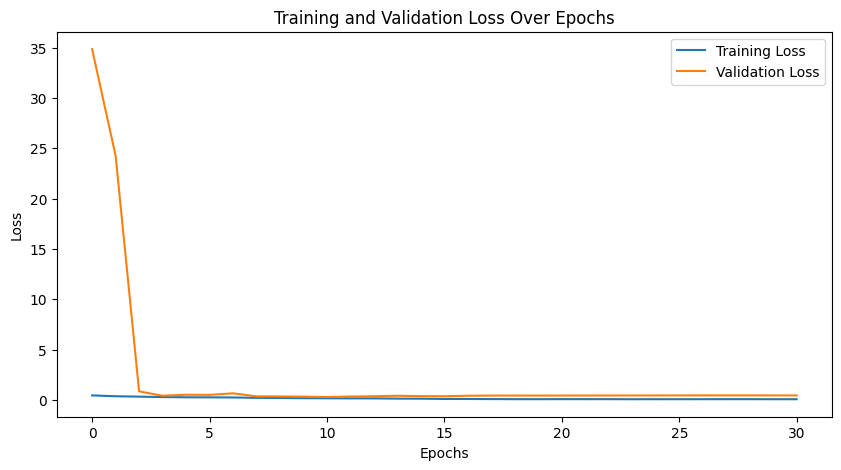

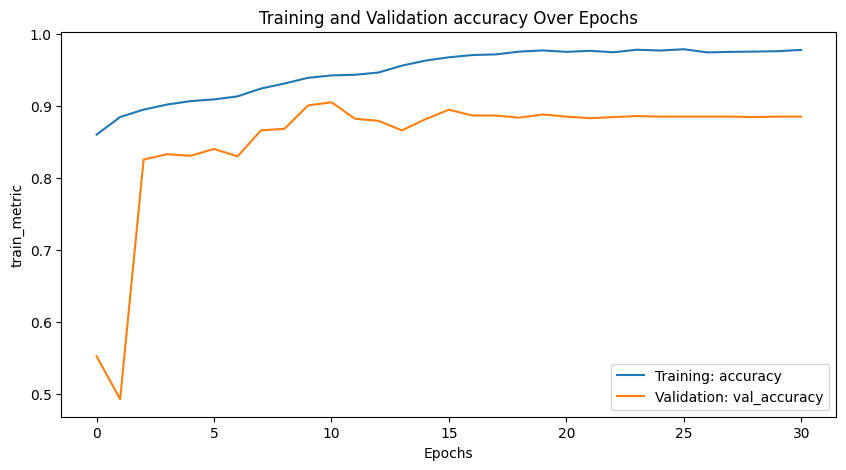

In [ ]:
plot_training_history(xc, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy')

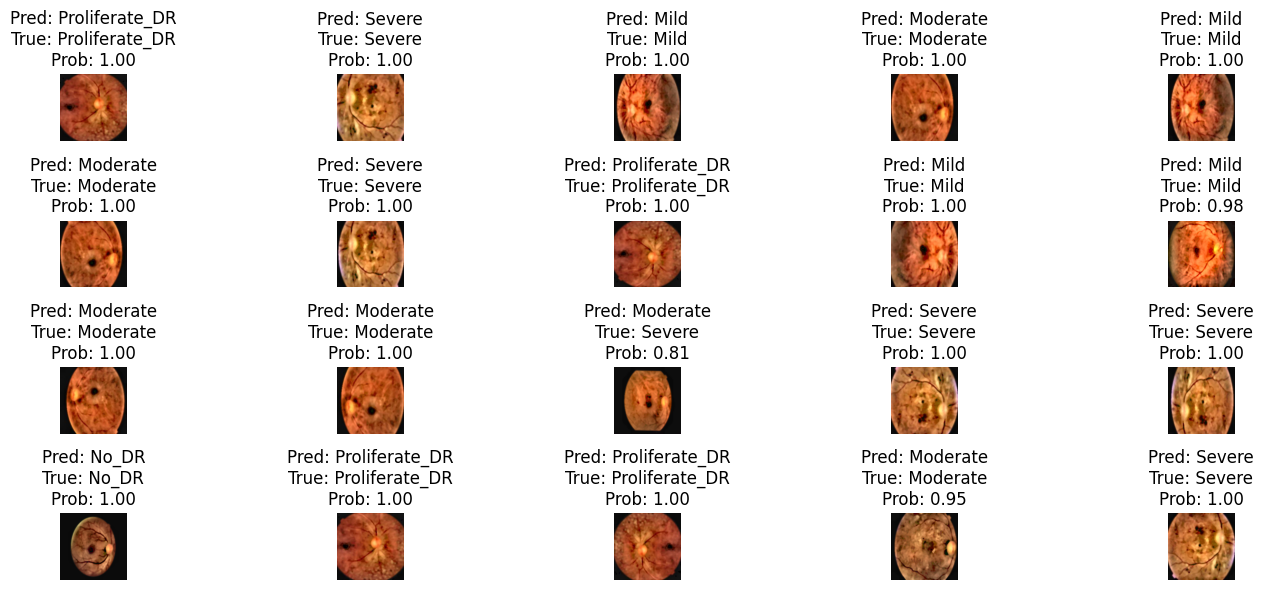

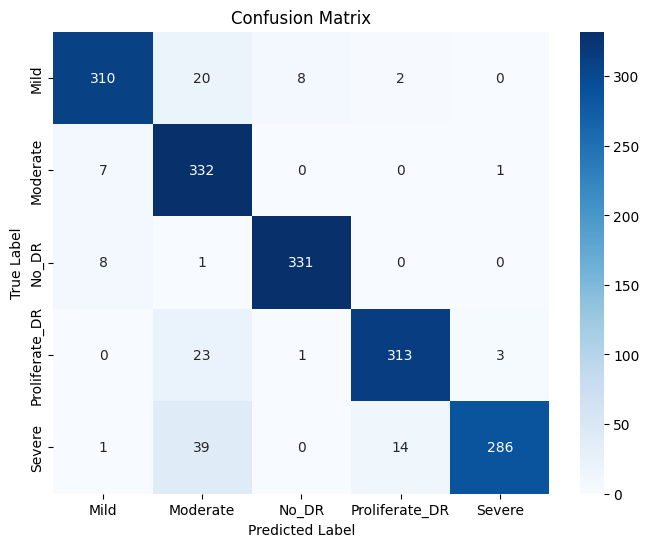

In [ ]:
modelxc=load_model("/content/drive/MyDrive/Colab Notebooks/Diyabetik Retinopati/my_model_vgg.keras")
predict_and_show_results(testdata, modelxc, dr_labels)
generate_confusion_matrix(testdata, modelxc, dr_labels)  # Karmaşıklık matrisini oluştur